---

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import integrate
from IPython import display

# Double Pendulum

A double pendulum consists of a normal pendulum with another pendulum hanging from its end. For simplicity I will be ignoring friction and assuming that both pendulums have bobs of the same mass $m$ and massless arms of the same length $\ell$. Thus the setup looks like this:

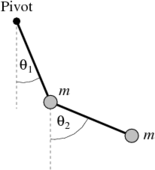

The position of the arms at any moment in time is uniquely specified by the two angles $\theta_1$ and $\theta_2$.  The equations of motion for the angles are most easily derived using the Lagrangian formalism. The resulting pair of equations are

$$\begin{align}
2\ddot\theta_1 + \ddot\theta_2 \cos(\theta_1-\theta_2) &+ \dot\theta_2^2 \sin(\theta_1-\theta_2) + 2{g\over\ell} \sin\theta_1 = 0\,,\\
\ddot\theta_2 + \ddot\theta_1 \cos(\theta_1-\theta_2) &- \dot\theta_1^2 \sin(\theta_1-\theta_2) + {g\over\ell} \sin\theta_2 = 0\,.
\end{align}$$

These are second-order equations, but they can be converted into first-order ones by defining two new variables, $\omega_1$ and $\omega_2$, thus:

$$\dot\theta_1 = \omega_1,\qquad \dot\theta_2 = \omega_2\,.$$

In terms of these variables the equations of motion become

$$\begin{align}
2\dot\omega_1 + \dot\omega_2 \cos(\theta_1-\theta_2) &+ \omega_2^2 \sin(\theta_1-\theta_2) + 2{g\over\ell} \sin\theta_1 = 0\,,\\
\dot\omega_2 + \dot\omega_1 \cos(\theta_1-\theta_2) &- \omega_1^2 \sin(\theta_1-\theta_2) + {g\over\ell} \sin\theta_2 = 0\,.
\end{align}$$

Finally, these can be rearranged into the standard form with a single derivative on the left-hand side of each one, which gives

$$\begin{align*}
\dot\omega_1 &= - {\omega_1^2\sin(2\theta_1-2\theta_2) + 2\omega_2^2\sin(\theta_1-\theta_2) + (g/\ell) \bigl[ \sin(\theta_1-2\theta_2) + 3 \sin\theta_1 \bigr]\over 3 - \cos(2\theta_1-2\theta_2)}, \\ \\
\dot\omega_2 &= {4\omega_1^2\sin(\theta_1-\theta_2) + \omega_2^2\sin(2\theta_1-2\theta_2) + 2(g/\ell) \bigl[ \sin(2\theta_1-\theta_2) - \sin\theta_2 \bigr]\over 3 - \cos(2\theta_1-2\theta_2)}.
\end{align*}$$

These two equations, along with the equations $\dot{\theta}_1=\omega_1$ and $\dot{\theta}_2=\omega_2$, give four first-order equations which between them define the motion of the double pendulum.

The first part of this program will solve the equations of motion from $t=0$ to $t=60$ seconds for the case where $\ell=0.4$ metters, with the initial conditions $\theta_1=\theta_2=\pi$ rad, $\omega_1=0$, and $\omega_2=0.001$ rad/s.

Additionally, it will find the mechanincal energy of the system over time, which is described by the equation

  $$E = m\ell^2 \bigl[ \omega_1^2 + \tfrac12 \omega_2^2 + \omega_1\omega_2 \cos(\theta_1-\theta_2) \bigr] - mg\ell(2\cos\theta_1 + \cos\theta_2)\,.$$

(Assume that there is a mass of $m=1$ kg)

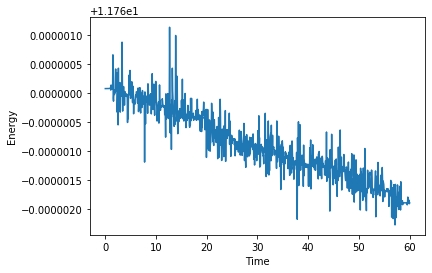

In [10]:
# Constants and variables as define in the above description
g = 9.8
# 1000 frames of animation
t = np.linspace(0, 60, 1000)
th1_0, th2_0 = np.pi, np.pi
w1_0, w2_0 = 0, 0.001
l = 0.4
m = 1


def f(t, r):
    """
    Takes a tuple of values, r, and uses the method of introducing two new
    variables (mentioned above) to define a new pair of ODEs to solve using scipy.
    """
    th1, th2, w1, w2 = r
    fth1 = w1
    fth2 = w2
    fw1 = -(w1**2*np.sin(2*th1-2*th2) + 2*w2**2*np.sin(th1-th2) + (g/l)*(np.sin(th1-2*th2) + 3*np.sin(th1)))/(3 - np.cos(2*th1-2*th2))
    fw2 = (4*w1**2*np.sin(th1-th2) + w2**2*np.sin(2*th1-2*th2) + (2*g/l)*(np.sin(2*th1-th2) - np.sin(th2)))/(3 - np.cos(2*th1-2*th2))
    return fth1, fth2, fw1, fw2

# Let's let scipy handle these ODEs for us
soln = integrate.solve_ivp(f, (0, 60), (th1_0, th2_0, w1_0, w2_0), t_eval = t, method = 'Radau', rtol = 1e-8)
# The solutions are placed into the attribute 'y'
th1, th2, w1, w2 = soln.y

# Use energy equation above to calulate the energy
E = m*l**2*(w1**2 + 0.5*w2**2 + w1*w2*np.cos(th1-th2)) - m*g*l*(2*np.cos(th1) + np.cos(th2))
plt.plot(t, E)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

What fun would this be without a real-time animation?

In [11]:
fig = plt.figure()
plt.axis("scaled")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
pbar = display.ProgressBar(1000)
pbar.display()

# the initial angles are both pi,
# but because of how I'm calculating x and y,
# subtracting by pi/2 visually puts the pendulum
# standing straight up, which matches the commonly
# seen initial conditions for a double pendulum
x1 = np.cos(th1 - np.pi/2)
y1 = np.sin(th1 - np.pi/2)
x2 = x1 + np.cos(th2 - np.pi/2)
y2 = y1 + np.sin(th2 - np.pi/2)

# represent the pendulum as a line with three points, i.e. two segments of equal length
x = [0, x1[0], x2[0]]
y = [0, y1[0], y2[0]]
pend, = plt.plot([], 'k-o')
    
def animate(frame):
    """
    I've already determined the proper x and y positions for the pendulum
    at a given time using the caluclated angles, so just use frame as an index
    for the coordinate arrays to get each subsequent position of the pendulum.
    """
    new_x = [0, x1[frame], x2[frame]]
    new_y = [0, y1[frame], y2[frame]]
    pend.set_data(new_x, new_y)
    pbar.progress = frame + 1

anim = FuncAnimation(fig, animate, frames=1000, interval=60)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

[============================================================] 1000/1000